In [1]:
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
def load_labeled_contracts(data_folder, modified=False):
    texts = []
    labels = []
    contract_ids = []
    contract_level_labels = []
    
    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.txt'):
                contract_path = os.path.join(root, file)
                contract_id = file  # Use file name as contract ID
                contract_level_label = 1 if modified else 0  # Assign contract-level label in addition to the line-level label

                with open(contract_path, 'r') as f:
                    for line in f:
                        line = line.strip()
                        if line:
                            label, text = line[0], line[1:].strip()
                            
                            # Filter lines with no alphabetic characters or shorter than 35 characters
                            if len(text) >= 35 and re.search(r'[a-zA-Z]', text):
                                labels.append(int(label))
                                texts.append(text)
                                contract_ids.append(contract_id)
                                contract_level_labels.append(contract_level_label)
    
    return texts, labels, contract_ids, contract_level_labels

In [3]:
modified_data_folder = "../tclp_content/modified_synthetic_data"
untouched_data_folder = "../tclp_content/untouched_synthetic_data"

In [4]:
texts, labels, contract_ids, contract_level_labels = load_labeled_contracts(modified_data_folder, modified=True)
texts_untouched, labels_untouched, contract_ids_untouched, contract_level_labels_untouched = load_labeled_contracts(untouched_data_folder)

In [5]:
texts = texts + texts_untouched
labels = labels + labels_untouched
contract_ids = contract_ids + contract_ids_untouched
contract_level_labels = contract_level_labels + contract_level_labels_untouched

In [6]:
data = pd.DataFrame({'contract_ids': contract_ids, 'text': texts, 'label': labels, 'contract_label': contract_level_labels})

In [7]:
#remove rows where text is empty
data = data[data['text'].str.strip().astype(bool)]

In [8]:
def load_clauses(data_folder):
    clause_texts = []
    clause_labels = []
    clause_ids = []

    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.txt'):
                clause_path = os.path.join(root, file)
                clause_id = file  # Use the file name as an identifier for each clause

                with open(clause_path, 'r') as f:
                    for line in f:
                        line = line.strip()
                        if line:
                            # Label every line in clause files as '1'
                            clause_labels.append(1)
                            clause_texts.append(line)
                            clause_ids.append(clause_id)

    return clause_texts, clause_labels, clause_ids

In [9]:
clause_folder = "../tclp_content/cleaned_clauses"

In [10]:
clause_texts, clause_labels, clause_ids = load_clauses(clause_folder)
clauses_df = pd.DataFrame({'contract_ids': clause_ids, 'text': clause_texts, 'label': clause_labels})
clauses_df['is_clause'] = 1
data['is_clause'] = 0

In [11]:
full_data = pd.concat([data, clauses_df], ignore_index=True)

In [12]:
ones = full_data[full_data['label'] == 1]
zeros = full_data[full_data['label'] == 0]
sampled_zeros = zeros.sample(n=len(ones), random_state=42)
balanced_data = pd.concat([ones, sampled_zeros])

In [13]:
#remove clauses from balanced data
balanced_data = balanced_data[balanced_data['is_clause'] == 0]

In [14]:
balanced_data = balanced_data.reset_index(drop=True)
balanced_data['unique_id'] = balanced_data.index

#shuffle the data but keep contracts together 
contract_ids = balanced_data['contract_ids'].unique()
contract_ids = contract_ids.tolist()
random.shuffle(contract_ids)

#reorder balanced_data based on new order of contract_ids
balanced_data = balanced_data.set_index('contract_ids')
balanced_data = balanced_data.loc[contract_ids]
balanced_data = balanced_data.reset_index(drop=False)

In [15]:
balanced_data

,contract_ids,text,label,contract_label,is_clause,unique_id
0,000011573.txt,1. Physical Risks:Climate Change is likely to ...,1,1.0,0,45358
1,000011573.txt,2. Transition Risks:The UK Government's curren...,1,1.0,0,45359
2,000011573.txt,It is targeting net zero emissions by 2050 wit...,1,1.0,0,45360
3,000011573.txt,Legislation is already in place to support thi...,1,1.0,0,45361
4,000011573.txt,We therefore anticipate the possibility of leg...,1,1.0,0,45362
...,...,...,...,...,...,...
162877,000003662.txt,Teddy's Clause Insert at purchase warranties f...,1,1.0,0,75165
162878,000003662.txt,This will build in long term environmental imp...,1,1.0,0,75166
162879,000003662.txt,At Purchase Warranty 1. As a Condition of this...,1,1.0,0,75167
162880,000003662.txt,2. The Supplier Undertakes:2.1 to develop and ...,1,1.0,0,75168


In [16]:
#split balanced_data so that the first 75% is the training set, the next 10% is the validation set, and the last 15% is the test set not using sklearn's train_test_split because we want to keep contracts together
train_size = int(0.75 * len(balanced_data))
val_size = int(0.1 * len(balanced_data))
test_size = int(0.15 * len(balanced_data))

train_data = balanced_data[:train_size]
val_data = balanced_data[train_size:train_size+val_size]
test_data = balanced_data[train_size+val_size:]

#remember the unique_id in each set so we can use it to get the corresponding predictions
train_ids = train_data['unique_id']
val_ids = val_data['unique_id']
test_ids = test_data['unique_id']

In [17]:
train_size = int(0.75 * len(balanced_data))
val_size = int(0.1 * len(balanced_data))
test_size = int(0.15 * len(balanced_data))

train_data = balanced_data[:train_size]
val_data = balanced_data[train_size:train_size+val_size]
test_data = balanced_data[train_size+val_size:]

In [18]:
train_ids = train_data['unique_id']
val_ids = val_data['unique_id']
test_ids = test_data['unique_id']

X_train = balanced_data[balanced_data['unique_id'].isin(train_ids)]['text'].tolist()
y_train = balanced_data[balanced_data['unique_id'].isin(train_ids)]['label'].tolist()
X_val = balanced_data[balanced_data['unique_id'].isin(val_ids)]['text'].tolist()
y_val = balanced_data[balanced_data['unique_id'].isin(val_ids)]['label'].tolist()
X_test = balanced_data[balanced_data['unique_id'].isin(test_ids)]['text'].tolist()
y_test = balanced_data[balanced_data['unique_id'].isin(test_ids)]['label'].tolist()

In [19]:
#add the clauses to the training data 
X_train = X_train + clause_texts
y_train = y_train + clause_labels

In [20]:
#shuffle within the sets 
train = list(zip(X_train, y_train))
random.shuffle(train)
X_train, y_train = zip(*train)

val = list(zip(X_val, y_val))
random.shuffle(val)
X_val, y_val = zip(*val)

test = list(zip(X_test, y_test))
random.shuffle(test)
X_test, y_test = zip(*test)

In [21]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [22]:
# Evaluate the model on the val set
y_pred = model.predict(X_val)
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8196
           1       0.96      0.97      0.96      8092

    accuracy                           0.96     16288
   macro avg       0.96      0.96      0.96     16288
weighted avg       0.96      0.96      0.96     16288

Accuracy Score: 0.9648821218074656


## Extrapolating to Contract-Level

In [23]:
val_data = pd.DataFrame({
    'contract_ids': balanced_data[balanced_data['unique_id'].isin(val_ids)]['contract_ids'].values,
    'text': X_val,
    'line_pred': y_pred,
    'true_label': y_val
})

In [24]:
contract_level_preds = val_data.groupby('contract_ids')['line_pred'].sum()

In [25]:
#sorted by number for each contract 
contract_level_preds.sort_values(ascending=False)

contract_ids
000011126.txt    80
000030544.txt    70
000004552.txt    65
000030373.txt    63
000007959.txt    61
                 ..
000007046.txt     0
000023310.txt     0
000023577.txt     0
000031525.txt     0
000019691.txt     0
Name: line_pred, Length: 763, dtype: int64

In [26]:
contract_level_true = balanced_data[balanced_data['unique_id'].isin(val_ids)].groupby('contract_ids')['contract_label'].max()

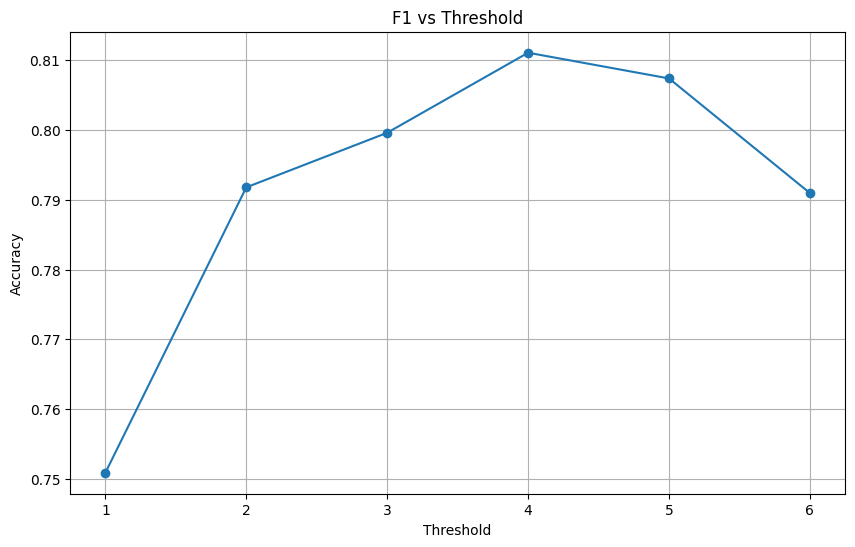

In [ ]:
thresholds = range(1, 7)
f1s = []

for threshold in thresholds:
    contract_level_preds_threshold = (contract_level_preds >= threshold).astype(int)
    f1 = f1_score(contract_level_true, contract_level_preds_threshold)
    f1s.append(f1)

# Plotting threshold vs f1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()

In [ ]:
best_threshold_index = f1s.index(max(f1s))
best_threshold = thresholds[best_threshold_index]
best_f1 = f1s[best_threshold_index]
accuracy = accuracy_score(contract_level_true, (contract_level_preds >= best_threshold).astype(int))
best_contract_level_preds = (contract_level_preds >= best_threshold).astype(int)

print(f"Best Threshold: {best_threshold}")
print("Best Threshold Contract-level Classification Report:\n", 
      classification_report(contract_level_true, best_contract_level_preds))
print("Best Threshold Contract-level F1 Score:", best_f1)
print("Best Threshold Contract-level Accuracy Score:", accuracy)

Best Threshold: 4
Best Threshold Contract-level Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.56      0.67       326
         1.0       0.74      0.90      0.81       437

    accuracy                           0.76       763
   macro avg       0.77      0.73      0.74       763
weighted avg       0.77      0.76      0.75       763

Best Threshold Contract-level F1 Score: 0.811088295687885
Best Threshold Contract-level Accuracy Score: 0.7588466579292268


## Test Data [Don't Run Until Done Refining]

In [29]:
#let's see how the model performs on the test set
y_pred_test = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Accuracy Score:", accuracy_score(y_test, y_pred_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     12370
           1       0.95      0.97      0.96     12063

    accuracy                           0.96     24433
   macro avg       0.96      0.96      0.96     24433
weighted avg       0.96      0.96      0.96     24433

Accuracy Score: 0.9629190029877625


In [30]:
test_data = pd.DataFrame({
    'contract_ids': balanced_data[balanced_data['unique_id'].isin(test_ids)]['contract_ids'].values,
    'text': X_test,
    'line_pred': y_pred_test,
    'true_label': y_test
})

In [31]:
contract_level_true = balanced_data[balanced_data['unique_id'].isin(test_ids)].groupby('contract_ids')['contract_label'].max()

In [32]:
threshold = 5

contract_level_preds_test = test_data.groupby('contract_ids')['line_pred'].sum()

contract_level_preds_threshold_test = (contract_level_preds_test >= threshold).astype(int)

print("Test Contract-level Classification Report:\n", 
      classification_report(contract_level_true, contract_level_preds_threshold_test))
print("Test Contract-level F1 Score:", f1_score(contract_level_true, contract_level_preds_threshold_test))
print("Test Contract-level Accuracy Score:", accuracy_score(contract_level_true, contract_level_preds_threshold_test))

Test Contract-level Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.64      0.70       509
         1.0       0.74      0.85      0.80       626

    accuracy                           0.76      1135
   macro avg       0.76      0.75      0.75      1135
weighted avg       0.76      0.76      0.75      1135

Test Contract-level F1 Score: 0.7955390334572491
Test Contract-level Accuracy Score: 0.7577092511013216
